In [1]:
library(magrittr)
library(tidyverse)
source("../data/env/variables.R")
source("~/wisdom/r/clean_theme.R")

options("readr.num_columns" = 0)

switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv") %>%
    filter(EnoughRecurrence == 1 & NotNoise==1 & IsModel==1 & Origin=="Tumor")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


In [2]:
psi.info <- lapply(c("luad","kirp","hnsc"), function(tumor){
    switches.tumor <- switches.split %>%
        filter(Tumor == tumor)
    pats <- lapply(switches.tumor$Patients_affected, function(x) strsplit(x, ",") %>% unlist )

    psi <- paste0("../data/psidiff/", tumor, "/psi.diff.txt") %>%
        read.table(check.names=FALSE) %>%
        mutate(., tx = rownames(.) %>% strsplit(",") %>% unlist %>% subset(c(F,T))) %>%
        filter(tx %in% unique(c(switches.tumor$Normal_transcript,switches.tumor$Tumor_transcript))) %>%
        gather(tx) %>% 
        set_colnames(c("tx","patient","deltapsi"))

    psi.p <- paste0("../data/psidiff/", tumor, "/psi.diff.p.txt") %>%
        read.table(check.names=FALSE) %>%
        mutate(., tx = rownames(.) %>% strsplit(",") %>% unlist %>% subset(c(F,T))) %>%
        filter(tx %in% unique(c(switches.tumor$Normal_transcript, switches.tumor$Tumor_transcript))) %>%
        gather(tx) %>% 
        set_colnames(c("tx","patient","p"))

    merge(psi, psi.p) %>%
        mutate(Tumor = tumor) %>%
        filter(!is.na(p)) %>%
        filter(tx %in% switches.tumor$Normal_transcript | tx %in% switches.tumor$Tumor_transcript )
}) %>% do.call("rbind", .)

Warning message:
“attributes are not identical across measure variables; they will be dropped”Warning message:
“attributes are not identical across measure variables; they will be dropped”Warning message:
“attributes are not identical across measure variables; they will be dropped”

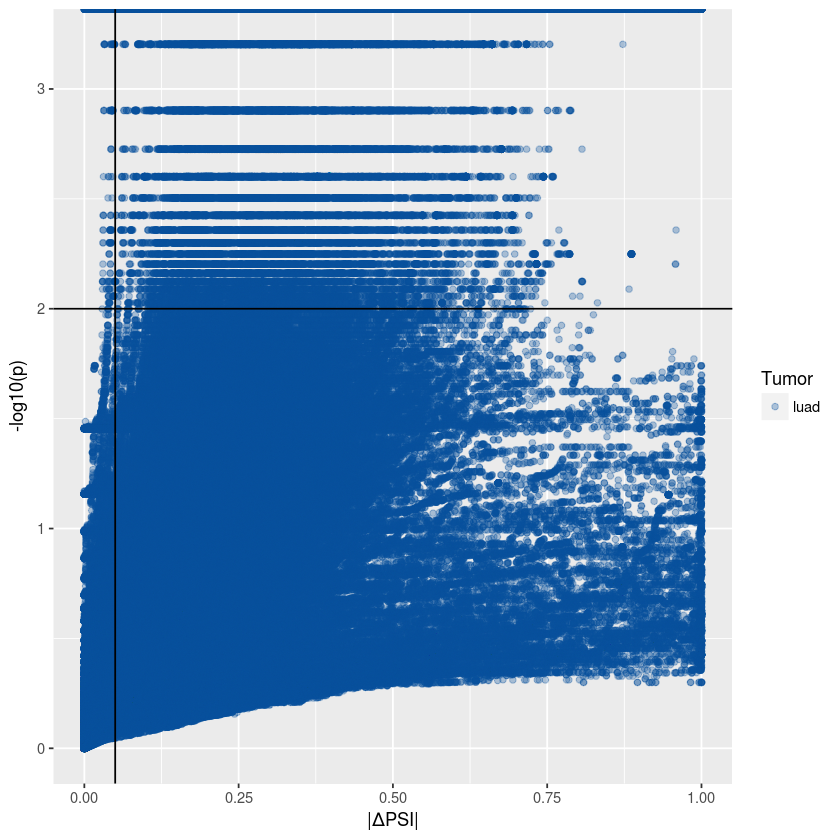

In [3]:
psi.info %>%
    filter(Tumor == "luad") %>%
    ggplot(aes(x = deltapsi, y = -log10(as.numeric(p)), color = Tumor)) + 
        geom_point(alpha = 0.3) +
        geom_vline(xintercept = 0.05) +
        geom_hline(yintercept = 2) +
        labs(x = "|ΔPSI|", y = "-log10(p)", color = "Tumor") +
        scale_color_manual(values = colorPalette)

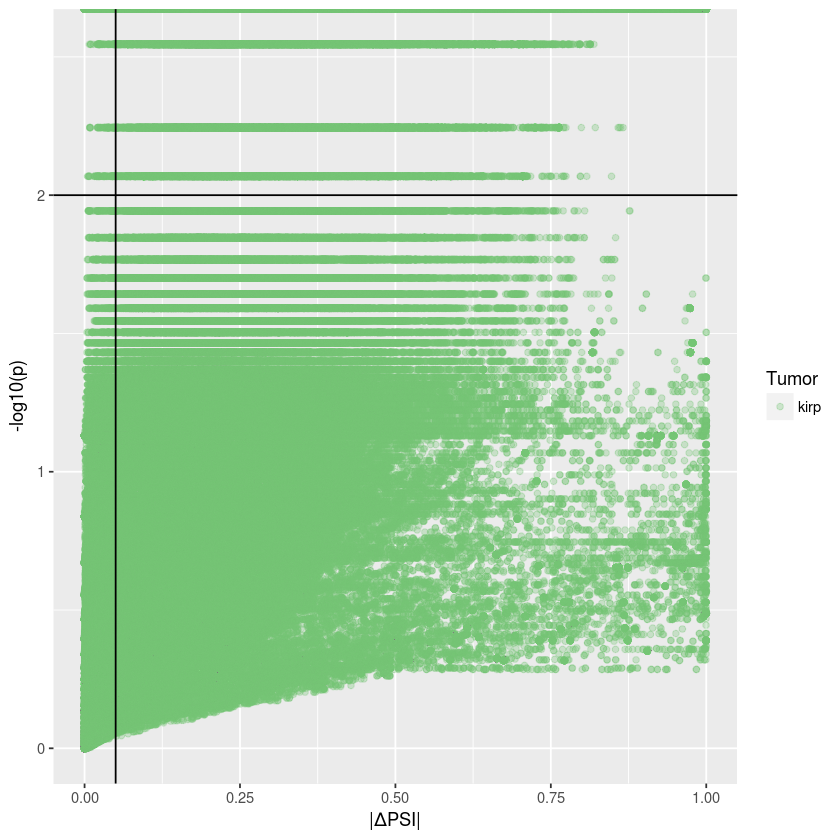

In [4]:
psi.info %>%
    filter(Tumor == "kirp") %>%
    ggplot(aes(x = deltapsi, y = -log10(as.numeric(p)), color = Tumor)) + 
        geom_point(alpha = 0.3) +
        geom_vline(xintercept = 0.05) +
        geom_hline(yintercept = 2) +
        labs(x = "|ΔPSI|", y = "-log10(p)", color = "Tumor") +
        scale_color_manual(values = colorPalette)

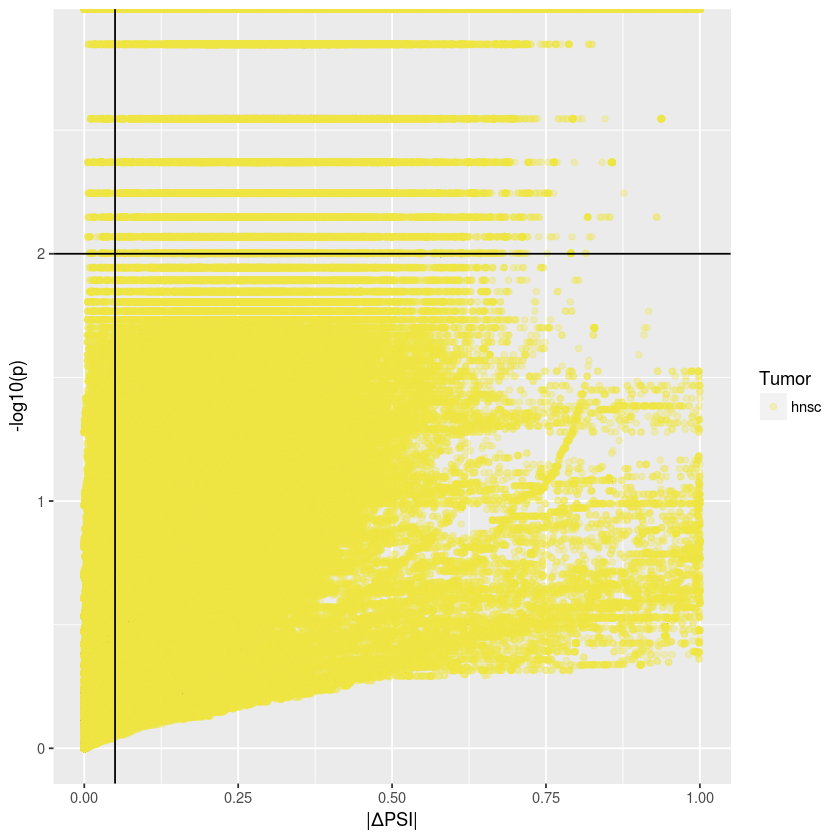

In [5]:
psi.info %>%
    filter(Tumor == "hnsc") %>%
    ggplot(aes(x = deltapsi, y = -log10(as.numeric(p)), color = Tumor)) + 
        geom_point(alpha = 0.3) +
        geom_vline(xintercept = 0.05) +
        geom_hline(yintercept = 2) +
        labs(x = "|ΔPSI|", y = "-log10(p)", color = "Tumor") +
        scale_color_manual(values = colorPalette)

Loading required package: RColorBrewer
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


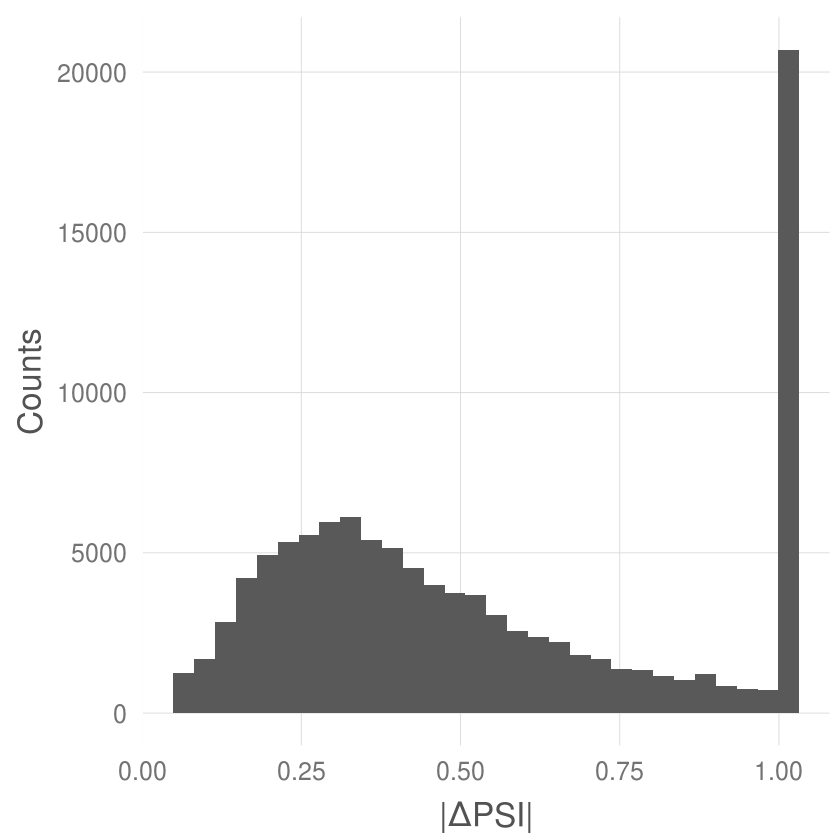

In [10]:
psi.info %>%
    filter(Tumor == "luad" & p < 0.01 & deltapsi > 0.05) %>%
    ggplot(aes(x = deltapsi)) + 
        geom_histogram() +
        labs(x = "|ΔPSI|", y = "Counts") + 
        clean_theme()